# 📘 Segmentación Semántica del Dataset FLAIR con SegNet  
### Basado en la estructura del código de *Beyond RGB: Very High Resolution Urban Remote Sensing With Multimodal Deep Networks* (Audebert et al.)

**Autor:** Avdoni Sanchez Reinoso 
**Programa:** Maestría en Geomática
**Institución:** — Universidad Nacional de Colombia 
**Fecha:** 2025  

---

## 🧩 Descripción General del Proyecto

Este notebook implementa un modelo **SegNet** para realizar **segmentación semántica** sobre el **dataset FLAIR #1**, utilizando imágenes aéreas multiespectrales (RGB, NIR) y datos de elevación (nDSM).  
El pipeline está fuertemente inspirado en la estructura del código desarrollado por:

**Nicolas Audebert, Bertrand Le Saux y Sébastien Lefèvre**  
*Beyond RGB: Very High Resolution Urban Remote Sensing With Multimodal Deep Networks*.

Aunque el artículo original emplea una arquitectura basada en **VGG-16 preentrenada**, este trabajo implementa un SegNet **entrenado desde cero**, adaptado para clasificar **13 categorías de uso/cobertura del suelo** del dataset FLAIR, manteniendo la lógica y organización del código base propuesto por los autores.

El objetivo es evaluar el rendimiento del modelo, analizar su comportamiento sobre datos multiespectrales y explorar ajustes de hiperparámetros que permitan obtener resultados comparables con literatura reciente en teledetección urbana.

---

## 🗂️ 1. Materiales

### 📌 **Dataset FLAIR #1 & #2**
El dataset FLAIR es provisto por IGN Francia: https://ignf.github.io/FLAIR/

Cada parche contiene:

| Fuente | Resolución | Bandas |
|-------|------------|--------|
| Imágenes aéreas | 512×512 px @ 0.2 m | R, G, B, NIR, nDSM |
| Series Sentinel-2 (opcional) | 10 m | 10 bandas |
| Máscaras de segmentación | 512×512 px | 19 clases (13 usadas en este trabajo) |

El conjunto FLAIR #1 incluye:
- 61 712 parches para entrenamiento y validación  
- 15 700 parches para prueba (test A)  
- 13 clases para tareas baseline  

Clases usadas:

1. Building  
2. Pervious surface  
3. Impervious surface  
4. Bare soil  
5. Water  
6. Coniferous  
7. Deciduous  
8. Brushwood  
9. Vineyard  
10. Herbaceous vegetation  
11. Agricultural land  
12. Plowed land  
13. Other  

---

### 💻 **Entorno de desarrollo**

Dado que el código del artículo original presenta dependencias antiguas, fue necesario crear un entorno adaptado con:

- **Python 3.10**  
- **PyTorch Nightly** con soporte CUDA 12.8 (necesario para GPUs NVIDIA serie 5000)  
- **scikit-learn, scikit-image, numpy, matplotlib**, en versiones compatibles  
- **Anaconda / Conda environment** para aislar dependencias  

La GPU utilizada para aceleración de entrenamiento fue una:

- **NVIDIA RTX 5060Ti – 8 GB VRAM**

---

### 🔍 Uso parcial del dataset FLAIR

Debido a las limitaciones computacionales del entorno local —principalmente la disponibilidad de **8 GB de VRAM** y un ancho de banda de memoria moderado— no se empleó la totalidad del dataset FLAIR para el entrenamiento del modelo.

En lugar de ello, se seleccionó un **subconjunto representativo** de los parches disponibles, garantizando que cada muestra incluyera al menos una de las 13 clases objetivo. Esto permite mantener una distribución razonablemente coherente del conjunto original, reduciendo al mismo tiempo la carga computacional.

Las cantidades finales utilizadas fueron:

- **12 000 imágenes** para entrenamiento (train)  
- **2 400 imágenes** para validación (val)  
- **2 400 imágenes** para prueba (test)  

Este muestreo estratificado preserva la presencia de todas las clases principales del dataset y hace viable el entrenamiento completo de la arquitectura SegNet sin exceder los recursos de hardware disponibles. Aunque se utiliza un subconjunto del dataset completo, la configuración empleada sigue siendo adecuada para analizar el comportamiento del modelo, evaluar hiperparámetros y obtener métricas comparables desde un enfoque experimental.

---


## ⚙️ 2. Metodología

Este trabajo sigue una metodología reproducible basada en la estructura del código de Audebert et al., con las siguientes fases:

### **1) Preparación del Dataset**
- Carga eficiente de imágenes aéreas y máscaras.
- Remapeo de etiquetas FLAIR → 13 clases.
- Normalización canal por canal.
- Inclusión opcional de *data augmentation* mediante recortes aleatorios (`random crop`).

### **2) Definición de la Red**
- Implementación de **SegNet completo** con encoder–decoder simétrico.
- Adaptación para 5 canales de entrada (RGB + NIR + nDSM).
- Funciones de activación ReLU y BatchNorm en cada bloque.
- Inicialización desde cero (no basado en VGG-16 preentrenado).

### **3) Entrenamiento del Modelo**
- Pérdida: **CrossEntropy** ponderada.
- Optimizador: **SGD** con momentum y weight decay.
- Scheduler: **MultiStepLR**.
- Aceleración: **AMP (Automatic Mixed Precision)**.
- Checkpoints automáticos cada *save_epoch* épocas.
- Visualización interactiva: curvas de pérdida y predicción/GT/RGB.

### **4) Evaluación del Modelo**
- Métricas principales:
  - Exactitud global  
  - **F1-score por clase**  
  - **Kappa de Cohen**  
  - Matriz de confusión normalizada  
- Inferencia sobre el test set con guardado de resultados RGB+GT+Pred.

### **5) Exportación de Resultados**
- Guardado de:
  - Predicciones por tile  
  - Checkpoints entrenados  
  - Figuras de curvas de pérdida  
  - Matrices de confusión  
  - RGB–GT–Pred concatenados  

---

## 📌 3. Configuración e Hiperparámetros Principales

| Parámetro | Valor | Descripción |
|----------|--------|-------------|
| `WINDOW_SIZE` | (256, 256) | Tamaño de crop aleatorio |
| `BATCH_SIZE` | 10 | VRAM disponible |
| `IN_CHANNELS` | 5 | RGB + NIR + DSM |
| `N_CLASSES` | 13 | Clases FLAIR baseline |
| `LR` | 0.005 (encoder/2 para decoder) | Learning rate inicial |
| `optimizer` | SGD (momentum=0.9) | Optimizador recomendado |
| `scheduler` | MultiStepLR | Ajustes en épocas clave |
| `save_epoch` | 5 | Frecuencia de checkpoints |

---

### 📚 Estructura del Notebook

El notebook está organizado en los siguientes módulos:

1. **Imports & Configuración básica**  
2. **Parámetros y rutas del dataset FLAIR**  
3. **Paletas de colores y utilidades de visualización**  
4. **Funciones auxiliares para métricas, ventanas, patching**  
5. **Generación del subset y filtrado por clases**  
6. **Dataset PyTorch + DataLoader optimizado**  
7. **Definición de SegNet**  
8. **Optimizador & Scheduler**  
9. **Función de evaluación**  
10. **Función de entrenamiento con AMP + guardado de ejemplos**  
11. **Inferencia por tiles y exportación de resultados**  
12. **Evaluación final del modelo**

---

Este proyecto constituye una implementación reproducible, limpia y extensible de una arquitectura SegNet adaptada para escenarios de teledetección multiespectral de muy alta resolución, con énfasis en la investigación y experimentación sobre el dataset FLAIR.

---


## 📦 Importación de librerías y configuración del entorno

Esta celda prepara el entorno de trabajo cargando todas las librerías necesarias para el procesamiento de imágenes, el manejo de tensores y la construcción del modelo de Deep Learning. Incluye:

- **Librerías estándar** utilizadas para manipulación de archivos, rutas y operaciones auxiliares.
- **NumPy**, para cálculos numéricos y manejo matricial.
- **scikit-image** y **matplotlib**, empleadas para lectura y visualización de imágenes.
- **IPython.display** para refrescar dinámicamente la salida del notebook durante el entrenamiento.
- **tqdm**, que permite mostrar barras de progreso en ciclos largos.
- **scikit-learn**, para el cálculo de métricas como F1-score, matriz de confusión y Kappa.
- **PyTorch**, módulo central para implementar el modelo SegNet, entrenarlo y aprovechar la aceleración por GPU.
- **tifffile**, necesario para cargar imágenes TIFF de gran formato utilizadas en el dataset FLAIR.

Además, se establece la configuración de reproducibilidad fijando una semilla global y se habilita `cudnn.benchmark`, lo cual permite optimizar el rendimiento en GPU. Finalmente, la celda determina automáticamente si se usará CPU o GPU para todas las operaciones posteriores.


In [2]:
# ---------- Librerías estándar ----------
import os
import time
import random
import itertools
from glob import glob

# ---------- NumPy / ciencia de datos ----------
import numpy as np

# ---------- Lectura de imágenes / visualización ----------
from skimage import io
from skimage import io as skio 
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

# ---------- Barra de progreso ----------
from tqdm.auto import tqdm

# ---------- Métricas sklearn ----------
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    cohen_kappa_score
)

# ---------- Torch / Deep Learning ----------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.amp as amp

# ---------- IO de TIFF ----------
import tifffile

# ============================================================
# REPRODUCIBILIDAD Y CONFIGURACIÓN DE CUDA/CUDNN
# ============================================================

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

cudnn.benchmark = True
cudnn.deterministic = False  # Poner a True solo si necesita resultados 100% reproducibles

# Dispositivo global
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")


Usando dispositivo: cuda


## 📌 Parámetros del dataset, clases y rutas principales

Esta celda define las variables centrales del proyecto relacionadas con el dataset FLAIR:

### 🖼️ Parámetros de configuración
- `WINDOW_SIZE`: tamaño de los recortes de imagen utilizados durante el entrenamiento.
- `IN_CHANNELS`: número de bandas de entrada (R, G, B, NIR, DSM).
- `BATCH_SIZE`: tamaño del batch utilizado por el DataLoader.
- `CACHE`: indicador opcional para futuras mejoras de lectura rápida.

### 🏷️ Definición de clases
Se especifican las **13 clases finales** usadas en el entrenamiento, junto con el conteo automático `N_CLASSES`.  
Se inicializa también un vector de pesos (`WEIGHTS`) utilizado posteriormente para balancear la función de pérdida.

### 📁 Rutas del dataset
Se definen las rutas locales hacia:
- conjunto **train/val**,
- **test1** (flair#1-test),
- **test2** (flair#2-test),

Estas rutas apuntan a la estructura oficial del dataset FLAIR una vez descomprimido.  
La celda imprime las rutas activas, permitiendo verificar que el dataset fue cargado correctamente antes de continuar con el pipeline de entrenamiento.


In [3]:
# Tamaño de las imágenes y batch
WINDOW_SIZE = (256, 256)   # luego podemos estudiar cambiar a 256x256 para acelerar
IN_CHANNELS = 5            # R,G,B,NIR,DSM
BATCH_SIZE = 10
CACHE = True

# Número de clases
LABELS = [
    "building", "pervious surface", "impervious surface", "bare soil",
    "water", "coniferous", "deciduous", "brushwood",
    "vineyard", "herbaceous vegetation", "agricultural land",
    "plowed land", "other"
]
N_CLASSES = len(LABELS)
WEIGHTS = torch.ones(N_CLASSES)

# ============================================================
# Rutas funcionales del dataset ya descomprimido
# ============================================================

BASE_FOLDER = r"G:\FLAIR_extracted"
TRAINVAL_DIR = os.path.join(BASE_FOLDER, "trainval")
TEST_DIR_1   = os.path.join(BASE_FOLDER, "test1")
TEST_DIR_2   = os.path.join(BASE_FOLDER, "test2")

print("Rutas activas:")
print("Train/Val:", TRAINVAL_DIR)
print("Test #1  :", TEST_DIR_1)
print("Test #2  :", TEST_DIR_2)


Rutas activas:
Train/Val: G:\FLAIR_extracted\trainval
Test #1  : G:\FLAIR_extracted\test1
Test #2  : G:\FLAIR_extracted\test2


## 🎨 Construcción de paleta FLAIR y visualización inicial

Esta celda realiza la configuración necesaria para trabajar con máscaras de segmentación usando la **paleta oficial del dataset FLAIR**. Incluye:

### ✔ Conversión de colores
- Se importa la paleta original proporcionada por los autores de FLAIR.
- Se implementa `hex2rgb` para convertir colores hexadecimales a tuplas RGB.
- Se genera una paleta ajustada a las 13 clases usadas en este proyecto.

Se crean dos funciones clave:
- `convert_to_color(arr_2d)`: convierte máscaras en escala de clases a imágenes RGB coloreadas.
- `convert_from_color(arr_3d)`: hace la conversión inversa, útil si se reciben máscaras en formato RGB.

### ✔ Comprobación de la paleta
Se verifica que todas las clases definidas en `LABELS` posean un color asignado.

### 🖼️ Visualización de ejemplo
Finalmente, la celda:
1. Busca en la carpeta *train/val* una imagen aérea FLAIR.
2. Localiza la máscara asociada.
3. Muestra en paralelo:
   - la imagen RGB original,
   - la máscara coloreada con la nueva paleta.

Esto permite validar que la estructura del dataset está correcta y que la paleta de colores funciona adecuadamente antes de iniciar la fase de preprocesamiento y entrenamiento.


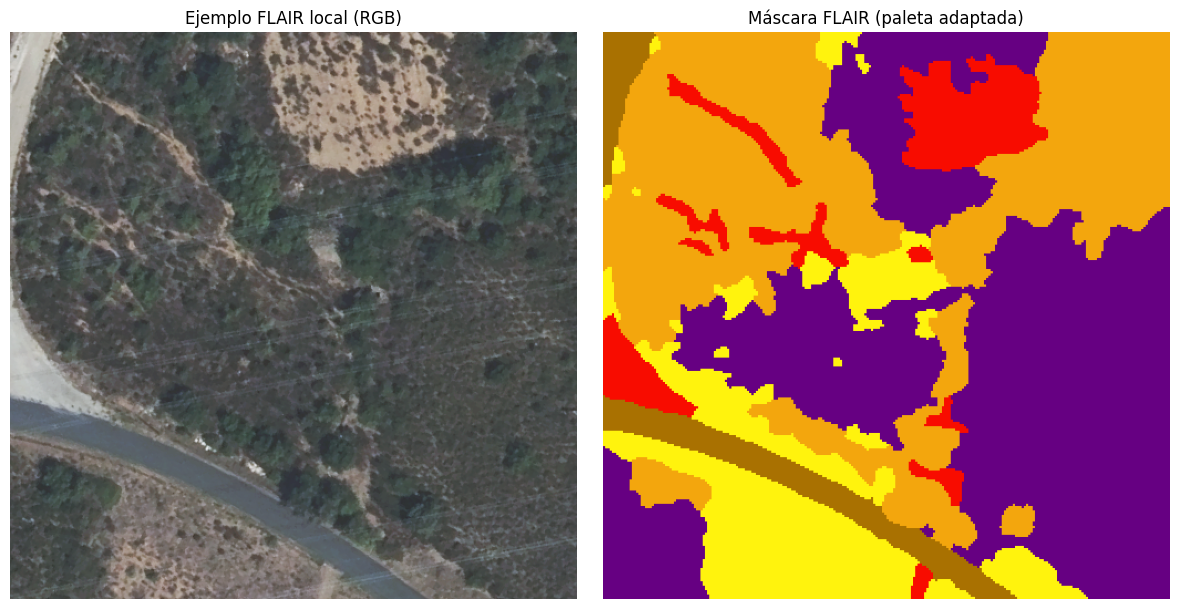

In [69]:
# Paleta oficial FLAIR (comentada en el notebook original) con hex
full_flair_palette = {
    1   : ['building',               '#db0e9a'],
    2   : ['pervious surface',       '#938e7b'],
    3   : ['impervious surface',     '#f80c00'],
    4   : ['bare soil',              '#a97101'],
    5   : ['water',                  '#1553ae'],
    6   : ['coniferous',             '#194a26'],
    7   : ['deciduous',              '#46e483'],
    8   : ['brushwood',              '#f3a60d'],
    9   : ['vineyard',               '#660082'],
    10  : ['herbaceous vegetation',  '#55ff00'],
    11  : ['agricultural land',      '#fff30d'],
    12  : ['plowed land',            '#e4df7c'],
    13  : ['swimming_pool',          '#3de6eb'],
    14  : ['snow',                   '#ffffff'],
    15  : ['clear cut',              '#8ab3a0'],
    16  : ['mixed',                  '#6b714f'],
    17  : ['ligneous',               '#c5dc42'],
    18  : ['greenhouse',             '#9999ff'],
    19  : ['other',                  '#000000'],
}

def hex2rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# Construyendo paleta 0..N_CLASSES-1
palette = {}  # {class_index: (R,G,B)}

name_to_index = {name: idx for idx, name in enumerate(LABELS)}

for _, (class_name, hex_color) in full_flair_palette.items():
    if class_name in name_to_index:
        idx = name_to_index[class_name]
        palette[idx] = hex2rgb(hex_color)

# Comprobamos colores
if len(palette) != N_CLASSES:
    print("[ADVERTENCIA] La paleta no tiene colores para todas las clases.")
    print("Clases en LABELS sin color:",
          [name for name in LABELS if name_to_index[name] not in palette])

# Paleta invertida para ir de RGB → índice
invert_palette = {rgb: idx for idx, rgb in palette.items()}


def convert_to_color(arr_2d, palette=palette):
    """
    Convierte una máscara de etiquetas (H, W) a RGB (H, W, 3)
    según el diccionario palette: {label: (R,G,B)}.
    """
    h, w = arr_2d.shape
    arr_3d = np.zeros((h, w, 3), dtype=np.uint8)
    for c, rgb in palette.items():
        arr_3d[arr_2d == c] = rgb
    return arr_3d


def convert_from_color(arr_3d, palette=invert_palette):
    """
    Convierte una máscara RGB (H, W, 3) a etiquetas (H, W)
    usando invert_palette: {(R,G,B): label}.
    Si algún color no está en la paleta, se asigna 0 por defecto.
    """
    h, w, _ = arr_3d.shape
    arr_2d = np.zeros((h, w), dtype=np.uint8)
    # vectorizado por colores
    for rgb, label in palette.items():
        mask = np.all(arr_3d == np.array(rgb).reshape(1, 1, 3), axis=2)
        arr_2d[mask] = label
    return arr_2d


# ============================================================
# Visualización de un ejemplo (imagen + máscara)
# ============================================================

sample_dirs = glob(os.path.join(TRAINVAL_DIR, "aerial", "*"))

if sample_dirs:
    # Tomamos la primera subcarpeta de aerial (por ejemplo Z1_AA)
    sample_img_paths = glob(os.path.join(sample_dirs[0], "IMG_*.tif"))
    if sample_img_paths:
        img_path = sample_img_paths[0]
        img = io.imread(img_path)

        # Construimos ruta de la máscara asociada
        rel_path = os.path.relpath(img_path, os.path.join(TRAINVAL_DIR, "aerial"))
        mask_rel = rel_path.replace("IMG_", "MSK_")
        mask_path = os.path.join(TRAINVAL_DIR, "labels", mask_rel)

        if os.path.exists(mask_path):
            msk_raw = io.imread(mask_path)

            if msk_raw.ndim == 3 and msk_raw.shape[2] == 3:
                msk_idx = convert_from_color(msk_raw)
            else:
                msk_idx = msk_raw

            msk_rgb = convert_to_color(msk_idx)

            fig, axes = plt.subplots(1, 2, figsize=(12, 6))

            axes[0].imshow(img[..., :3])
            axes[0].set_title("Ejemplo FLAIR local (RGB)")
            axes[0].axis("off")

            axes[1].imshow(msk_rgb)
            axes[1].set_title("Máscara FLAIR (paleta adaptada)")
            axes[1].axis("off")

            plt.tight_layout()
            plt.show()
        else:
            print("No se encontró la máscara asociada a:", img_path)
    else:
        print("No se encontraron imágenes en la carpeta:", sample_dirs[0])
else:
    print("No se encontraron subcarpetas en Train/Val.")


# 🔧 Funciones utilitarias para extracción de parches, métricas y operaciones auxiliares

Esta celda reúne un conjunto de utilidades esenciales para el procesamiento de imágenes y el cálculo de métricas de segmentación dentro del flujo de trabajo del proyecto. Estas funciones complementan al dataset FLAIR y al modelo SegNet proporcionando operaciones fundamentales para preparar los datos y evaluar el desempeño del modelo.

### 🔹 1. `get_random_pos`
Permite extraer **parches aleatorios** dentro de una imagen, lo cual es clave para el mecanismo de *random crop* empleado durante el entrenamiento. Este muestreo espacial ayuda a exponer al modelo a variabilidad intraimagen y previene el sobreajuste.

### 🔹 2. `CrossEntropy2d`
Wrapper adaptado de la función estándar de PyTorch para calcular la **pérdida de entropía cruzada** en tareas de segmentación, aceptando tensores 2D o tensores aplanados. Garantiza compatibilidad con diferentes formas de entrada.

### 🔹 3. `accuracy`
Calcula el **accuracy pixel-wise**, una métrica rápida que evalúa qué porcentaje de pixeles fueron predichos correctamente.

### 🔹 4. `sliding_window` y `count_sliding_window`
Implementan una **ventana deslizante (sliding window)** para recorrer imágenes grandes en pasos controlados.  
Son útiles para tareas de inferencia sobre imágenes completas y para estimar cuántos parches serán generados.

### 🔹 5. `grouper`
Divide un iterable en grupos de tamaño fijo, lo cual es útil cuando se requiere procesar elementos en lotes.

### 🔹 6. `metrics`
Función completa de evaluación que calcula:
- Matriz de confusión  
- Accuracy global  
- F1-score por clase  
- Estadístico Kappa de Cohen  

Esta función es valiosa para obtener una caracterización detallada del rendimiento del modelo más allá del accuracy, especialmente en datasets con clases desbalanceadas como FLAIR.


In [8]:
# ============================================================
# UTILITIES ADAPTADOS PARA FLAIR
# ============================================================

# -------------------------
# 1. Extracción de parches aleatorios
# -------------------------
def get_random_pos(img, window_shape):
    """
    Extrae un parche aleatorio dentro de la imagen.
    img: array o tensor con shape [..., H, W]
    window_shape: (h, w)
    """
    h, w = window_shape
    H, W = img.shape[-2], img.shape[-1]

    if H < h or W < w:
        raise ValueError(f"La ventana {window_shape} no cabe en la imagen {img.shape[-2:]}")

    x1 = random.randint(0, H - h)
    y1 = random.randint(0, W - w)
    return x1, x1 + h, y1, y1 + w

# -------------------------
# 2. CrossEntropy para segmentación 2D
# -------------------------
def CrossEntropy2d(input, target, weight=None, size_average=True):
    """
    CrossEntropy para segmentación 2D.
    Soporta input de shape:
        - (N, C, H, W)
        - (N*H*W, C) flattened
    """
    if input.dim() == 2:
        return F.cross_entropy(
            input, target, weight=weight,
            reduction='mean' if size_average else 'none'
        )
    elif input.dim() == 4:
        N, C, H, W = input.shape
        input_flat = input.permute(0, 2, 3, 1).contiguous().view(-1, C)
        target_flat = target.view(-1)
        return F.cross_entropy(
            input_flat, target_flat, weight=weight,
            reduction='mean' if size_average else 'none'
        )
    else:
        raise ValueError(f"CrossEntropy2d recibió dimensiones inesperadas: {input.shape}")

# -------------------------
# 3. Accuracy pixel-wise
# -------------------------
def accuracy(pred, target):
    """
    Accuracy pixel-wise.
    pred y target: arrays o tensores del mismo tamaño
    """
    pred = np.asarray(pred).ravel()
    target = np.asarray(target).ravel()
    return 100.0 * np.count_nonzero(pred == target) / len(target)

# -------------------------
# 4. Ventana deslizante
# -------------------------
def sliding_window(img, step=10, window_size=(20,20)):
    """
    Generador de ventana deslizante sobre la imagen.
    Devuelve: x, y, h, w
    """
    H, W = img.shape[:2]
    h, w = window_size

    for x in range(0, H, step):
        if x + h > H:
            x = H - h
        for y in range(0, W, step):
            if y + w > W:
                y = W - w
            yield x, y, h, w

def count_sliding_window(img, step=10, window_size=(20,20)):
    """
    Cuenta cuántos parches genera sliding_window.
    """
    return sum(1 for _ in sliding_window(img, step=step, window_size=window_size))

# -------------------------
# 5. Agrupar iterable en chunks
# -------------------------
def grouper(n, iterable):
    """
    Agrupa iterable en chunks de tamaño n
    """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            break
        yield chunk

# -------------------------
# 6. Métricas de segmentación
# -------------------------
def metrics(predictions, gts, label_values=LABELS):
    """
    Cálculo de métricas para segmentación:
    - Matriz de confusión
    - Accuracy global
    - F1 por clase
    - Kappa de Cohen
    """
    predictions = predictions.astype(np.int64).ravel()
    gts = gts.astype(np.int64).ravel()
    labels = np.arange(len(label_values))

    cm = confusion_matrix(gts, predictions, labels=labels)

    print("Confusion matrix:")
    print(cm)
    print("---")

    total_pixels = cm.sum()
    acc = np.trace(cm) / total_pixels * 100
    print(f"{total_pixels} pixels procesados")
    print(f"Accuracy total: {acc:.4f}%")
    print("---")

    # F1 por clase
    F1Score = np.zeros(len(label_values), dtype=np.float32)
    for i in range(len(label_values)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        denom = (2 * TP + FP + FN)
        F1Score[i] = 2 * TP / denom if denom != 0 else 0.0

    print("F1Score por clase:")
    for i, score in enumerate(F1Score):
        print(f"{label_values[i]}: {score:.4f}")
    print("---")

    # Kappa de Cohen
    pa = np.trace(cm) / total_pixels
    pe = (cm.sum(axis=0) * cm.sum(axis=1)).sum() / (total_pixels ** 2)
    kappa = (pa - pe) / (1 - pe)
    print(f"Kappa: {kappa:.4f}")

    return acc


## 🗂️ Construcción del subset de entrenamiento/validación y filtrado por clases

Esta celda automatiza la construcción del **subset** de entrenamiento y validación utilizado en el proyecto.  
Debido al tamaño del dataset FLAIR, se selecciona aleatoriamente un porcentaje de zonas y luego se filtran únicamente aquellas imágenes que contienen clases relevantes.

### 🔹 Configuración general
- Se define el porcentaje del dataset a utilizar (`SUBSET_PERCENT`).
- Se especifica la proporción de división entre entrenamiento y validación (`TRAIN_RATIO`).
- Se establecen límites superiores de imágenes para evitar exceder la memoria del sistema.

### 🔹 Remapeo de clases
Se crea una tabla (`remap_lut`) que convierte las etiquetas originales del dataset (1–19) a **13 clases consolidadas**, acorde con la configuración del proyecto.  
Esto garantiza coherencia entre las máscaras originales y el modelo.

### 🔹 Selección de zonas
El script:
1. Identifica todas las zonas en `trainval/`.
2. Selecciona aleatoriamente un subset.
3. Divide dicho subset en entrenamiento y validación.

### 🔹 Filtrado con verificación de clases
Antes de agregar una imagen al conjunto de entrenamiento o validación, se comprueba si la máscara contiene **al menos una de las clases esperadas**, asegurando que las muestras sean informativas.

### 🔹 Distribución final
Al finalizar, la celda:
- Construye listas definitivas de rutas de imágenes y máscaras.
- Limita el número máximo de imágenes si es necesario.
- Imprime la cantidad final de muestras en cada split.

Estas rutas serán consumidas por los DataLoaders en la siguiente celda.


In [11]:
# ============================================================
#  Subset rápido con validación de clases
# ============================================================

# ============================================
# CONFIGURACIÓN
# ============================================

BASE_FOLDER = r"G:\FLAIR_extracted"
TRAINVAL_DIR = os.path.join(BASE_FOLDER, "trainval")

SUBSET_PERCENT = 0.35
TRAIN_RATIO = 0.8

# Límite de imágenes para nuevo Subset
MAX_TRAIN_IMAGES = 12000  
MAX_VAL_IMAGES   = 2400  

# ============================================
# Diccionario de remapeo: etiquetas originales → 0..12
# ============================================

remap_labels = {
    1: 0,   # building
    2: 1,   # pervious surface
    3: 2,   # impervious surface
    4: 3,   # bare soil
    5: 4,   # water
    6: 5,   # coniferous
    7: 6,   # deciduous
    8: 7,   # brushwood
    9: 8,   # vineyard
    10: 9,  # herbaceous vegetation
    11: 10, # agricultural land
    12: 11, # plowed land
    19: 12, # other
}

remap_lut = np.zeros(256, dtype=np.int64)
for orig, new in remap_labels.items():
    remap_lut[orig] = new

# ============================================
# 1. Identificar todas las zonas dentro de trainval/
# ============================================

zones = sorted(os.listdir(os.path.join(TRAINVAL_DIR, "aerial")))
print(f"Zonas encontradas en trainval: {len(zones)}")
print(zones[:10], "...")

# ============================================
# 2. Seleccionar subset inicial
# ============================================

subset_size = max(1, int(len(zones) * SUBSET_PERCENT))
subset_zones = random.sample(zones, subset_size)
print(f"\nSubset inicial de {subset_size} zonas:")
print(subset_zones[:10], "...")

# ============================================
# 3. Función para comprobar si máscara contiene clases 1..13
# ============================================

def mask_has_required_classes(mask_path, required_classes=set(range(1,14))):
    mask = tifffile.imread(mask_path)
    unique_vals = set(np.unique(mask))
    return len(unique_vals & required_classes) > 0

# ============================================
# 4. Filtrar imágenes dentro del subset que contienen clases 1..13
# ============================================

def collect_paths_filtered(split_zones):
    images = []
    labels = []
    for zone in split_zones:
        aerial_dir = os.path.join(TRAINVAL_DIR, "aerial", zone)
        labels_dir = os.path.join(TRAINVAL_DIR, "labels", zone)

        imgs = sorted(glob(os.path.join(aerial_dir, "IMG_*.tif")))
        msks = sorted(glob(os.path.join(labels_dir, "MSK_*.tif")))

        if len(imgs) != len(msks):
            limit = min(len(imgs), len(msks))
            imgs = imgs[:limit]
            msks = msks[:limit]

        # Filtrar solo máscaras con clases 1..13
        for im, msk in zip(imgs, msks):
            if mask_has_required_classes(msk):
                images.append(im)
                labels.append(msk)

    return images, labels

# ============================================
# 5. Dividir subset en train / val
# ============================================

random.shuffle(subset_zones)
split_idx = int(len(subset_zones) * TRAIN_RATIO)
train_zones = subset_zones[:split_idx]
val_zones   = subset_zones[split_idx:]

train_images, train_labels = collect_paths_filtered(train_zones)
val_images, val_labels     = collect_paths_filtered(val_zones)

# (Opcional) limitar aún más el número de imágenes si se desea
if MAX_TRAIN_IMAGES is not None and len(train_images) > MAX_TRAIN_IMAGES:
    idxs = np.random.choice(len(train_images), size=MAX_TRAIN_IMAGES, replace=False)
    train_images = [train_images[i] for i in idxs]
    train_labels = [train_labels[i] for i in idxs]

if MAX_VAL_IMAGES is not None and len(val_images) > MAX_VAL_IMAGES:
    idxs = np.random.choice(len(val_images), size=MAX_VAL_IMAGES, replace=False)
    val_images = [val_images[i] for i in idxs]
    val_labels = [val_labels[i] for i in idxs]

print(f"\nTrain images: {len(train_images)}")
print(f"Val images:   {len(val_images)}")

# ============================================
# Variables finales
# ============================================

TRAIN_IMAGE_PATHS = train_images
TRAIN_LABEL_PATHS = train_labels
VAL_IMAGE_PATHS   = val_images
VAL_LABEL_PATHS   = val_labels

print("\nRutas listas para el dataset.")


Zonas encontradas en trainval: 357
['Z10_AA', 'Z10_AU', 'Z10_FA', 'Z10_FF', 'Z10_FN', 'Z10_FU', 'Z10_NF', 'Z10_NN', 'Z10_UA', 'Z10_UF'] ...

Subset inicial de 124 zonas:
['Z7_UU', 'Z14_FN', 'Z10_UU', 'Z20_UA', 'Z1_AF', 'Z19_AA', 'Z15_FU', 'Z13_UU', 'Z9_FA', 'Z53_UN'] ...

Train images: 12000
Val images:   2400

Rutas listas para el dataset.


## 🧩 Implementación del Dataset FLAIR con random crop, data augmentation y creación de Dataloaders

Esta celda define la clase `FlairDataset`, una implementación personalizada de PyTorch para cargar imágenes del dataset FLAIR, aplicar transformaciones y preparar los datos para el entrenamiento.

### 🔹 Funcionalidades clave del Dataset

#### **1. Lectura robusta de imágenes**
Soporta imágenes con distintas configuraciones de canales, asegurando una conversión correcta a formato `(C, H, W)`.

#### **2. Normalización**
Las imágenes se escalan a **[0,1]** dependiendo del tipo de dato original (uint8 o uint16).

#### **3. Random Crop**
Si está habilitado, extrae parches aleatorios del tamaño definido en `WINDOW_SIZE`, permitiendo:
- aumentar la variación espacial,
- reducir memoria,
- entrenar con fragmentos independientes.

#### **4. Data Augmentation**
Disponible únicamente en el conjunto de entrenamiento (`augment=True`):
- Rotaciones aleatorias de 0°, 90°, 180°, 270°  
- Flip horizontal aleatorio  
- Flip vertical aleatorio  

Estas transformaciones ayudan a mejorar la capacidad de generalización del modelo.

#### **5. Eliminación de strides negativos**
Se usa `.copy()` para evitar errores al convertir los arrays a tensores PyTorch.

---

### 🔹 Creación del dataset y dataloaders

Se instancian:

- **train_set**: con *random crop* y *augmentation*
- **val_set**: sin modificaciones adicionales
- **test_set**: actualmente idéntico a val_set (placeholder)

Los DataLoaders:
- habilitan *mini-batches*,
- mezclan aleatoriamente la data en entrenamiento,
- optimizan la transferencia CPU → GPU mediante `pin_memory=True`.

Se imprime un resumen indicando el número total de batches en cada loader.

Esta celda completa deja el pipeline de datos en condiciones óptimas para iniciar el proceso de entrenamiento del modelo SegNet.


In [25]:
# ============================================================
# Dataset FLAIR + Dataloaders (con random crop + augmentation)
# ============================================================

class FlairDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths,
                 normalize=True,
                 window_size=WINDOW_SIZE,
                 random_crop=True,
                 augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.normalize = normalize

        # 🔹 Soporte para crops aleatorios 
        self.window_size = window_size
        self.random_crop = random_crop and (window_size is not None)

        # 🔹 Data augmentation (rotaciones / flips)
        self.augment = augment

        print(
            f"Dataset FlairDataset creado con {len(self.image_paths)} muestras. "
            f"random_crop={self.random_crop}, augment={self.augment}"
        )

    def __len__(self):
        return len(self.image_paths)

    def _load_image(self, img_path):
        # Cargar imagen
        try:
            img = tifffile.imread(img_path)
        except Exception:
            img = skio.imread(img_path)

        # Asegurar shape (C, H, W)
        if img.ndim == 2:
            img = img[np.newaxis, ...]  # (1, H, W)
        elif img.ndim == 3:
            if img.shape[-1] <= 8:
                img = img.transpose((2, 0, 1))  # (C, H, W)
            elif img.shape[0] <= 8:
                # ya está (C, H, W)
                pass
            else:
                raise ValueError(f"Formato inesperado {img_path}: {img.shape}")
        else:
            raise ValueError(f"Formato inesperado {img_path}: {img.shape}")

        orig_dtype = img.dtype
        img = img.astype(np.float32, copy=False)

        # Escalamos a [0,1] según el tipo de origen
        if self.normalize:
            if np.issubdtype(orig_dtype, np.integer):
                max_val = 65535.0 if orig_dtype == np.uint16 else 255.0
                if max_val > 0:
                    img /= max_val
            else:
                # Si ya viene en float asumimos [0,1] o similar
                pass

        return img

    def _load_mask(self, msk_path):
        try:
            msk = tifffile.imread(msk_path)
        except Exception:
            msk = skio.imread(msk_path)

        # Convertir a 2D de índices
        if msk.ndim == 3 and msk.shape[2] == 3:
            try:
                msk = convert_from_color(msk)
            except Exception:
                msk = msk[..., 0]
        if msk.ndim == 3:
            msk = msk[0] if msk.shape[0] <= 8 else msk[..., 0]

        msk_arr = np.asarray(msk, dtype=np.uint8)

        # remap_lut debe estar definido antes: remap_lut = np.zeros(256, dtype=np.uint8); ...
        msk_remapped = remap_lut[msk_arr]

        return msk_remapped

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        msk_path = self.mask_paths[idx]

        img = self._load_image(img_path)          # (C, H, W), float32
        msk_remapped = self._load_mask(msk_path)  # (H, W), uint8 indices 0..12

        # 🔹 Crop aleatorio según WINDOW_SIZE
        if self.random_crop and self.window_size is not None:
            x1, x2, y1, y2 = get_random_pos(img, self.window_size)
            img = img[:, x1:x2, y1:y2]
            msk_remapped = msk_remapped[x1:x2, y1:y2]

                # 🔹 Data augmentation sencillo (solo si self.augment == True)
        if self.augment:
            # Rotación aleatoria 0,90,180,270
            k = random.randint(0, 3)
            if k > 0:
                img = np.rot90(img, k, axes=(1, 2))              # (C,H,W)
                msk_remapped = np.rot90(msk_remapped, k, axes=(0, 1))  # (H,W)

            # Flip horizontal aleatorio
            if random.random() < 0.5:
                img = np.flip(img, axis=2)          # eje W
                msk_remapped = np.flip(msk_remapped, axis=1)

            # Flip vertical aleatorio
            if random.random() < 0.5:
                img = np.flip(img, axis=1)          # eje H
                msk_remapped = np.flip(msk_remapped, axis=0)

        # 🔹 IMPORTANTE: copiar para eliminar strides negativos
        img = img.copy()
        msk_remapped = msk_remapped.copy()

        # A tensores
        img_tensor = torch.from_numpy(img).float()
        mask_tensor = torch.from_numpy(msk_remapped.astype(np.int64))

        return img_tensor, mask_tensor



# ============================
# Crear datasets
# ============================

train_set = FlairDataset(
    TRAIN_IMAGE_PATHS,
    TRAIN_LABEL_PATHS,
    normalize=True,
    window_size=WINDOW_SIZE,
    random_crop=True,   # puedes poner False si no quieres crops
    augment=True        # 🔹 augment SOLO en entrenamiento
)

val_set = FlairDataset(
    VAL_IMAGE_PATHS,
    VAL_LABEL_PATHS,
    normalize=True,
    window_size=WINDOW_SIZE,
    random_crop=False,
    augment=False
)

# Ahora mismo usas val como test placeholder
test_set = FlairDataset(
    VAL_IMAGE_PATHS,
    VAL_LABEL_PATHS,
    normalize=True,
    window_size=WINDOW_SIZE,
    random_crop=False,
    augment=False
)

# ============================
# Dataloaders
# ============================

NUM_WORKERS = 0  # en tu máquina funcionó mejor así

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=False
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=False
)

test_loader = DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=False
)

print("Dataloaders listos.")
print("len(train_loader) =", len(train_loader))
print("len(val_loader)   =", len(val_loader))
print("len(test_loader)  =", len(test_loader))


Dataset FlairDataset creado con 12000 muestras. random_crop=True, augment=True
Dataset FlairDataset creado con 2400 muestras. random_crop=False, augment=False
Dataset FlairDataset creado con 2400 muestras. random_crop=False, augment=False
Dataloaders listos.
len(train_loader) = 1200
len(val_loader)   = 240
len(test_loader)  = 2400


### 🔍 Validaciones rápidas del DataLoader

Antes de iniciar el entrenamiento, estas celdas permiten verificar que los datos se cargan correctamente.  
Se revisa:

- El tiempo de carga del primer batch.
- Las formas de las imágenes y máscaras.
- Los valores mínimo y máximo de las máscaras (para confirmar el remapeo de clases).
  
Estas pruebas no forman parte del modelo, pero ayudan a detectar problemas en el pipeline de datos antes de ejecutar entrenamientos largos.

In [27]:
start = time.time()
imgs, msks = next(iter(train_loader))
end = time.time()

print("Batch shapes:", imgs.shape, msks.shape)
print("Mask min/max:", msks.min().item(), msks.max().item())
print(f"Tiempo en cargar primer batch: {end - start:.2f} s")


Batch shapes: torch.Size([10, 5, 256, 256]) torch.Size([10, 256, 256])
Mask min/max: 0 10
Tiempo en cargar primer batch: 0.31 s


In [29]:
for imgs, msks in train_loader:
    print("Batch shapes:", imgs.shape, msks.shape)
    print("Mask min/max:", msks.min().item(), msks.max().item())
    break


Batch shapes: torch.Size([10, 5, 256, 256]) torch.Size([10, 256, 256])
Mask min/max: 0 10


### 🔧 Definición de la arquitectura SegNet adaptada a FLAIR

Esta celda implementa una versión clásica de **SegNet**, una red encoder–decoder diseñada para segmentación semántica.  
El modelo mantiene la estructura propuesta por Audebert et al. (Beyond RGB), pero se adapta al número de canales del dataset FLAIR (5 canales) y a 13 clases de salida.

**Puntos clave de la arquitectura:**

- **Encoder (5 bloques):**  
  Cada bloque aplica varias convoluciones 3×3 seguidas de BatchNorm y ReLU.  
  El *MaxPool* se usa con `return_indices=True` para guardar las posiciones de los valores máximos, necesarios en el decoder.

- **Pooling con índices:**  
  SegNet no usa interpolación; en su lugar, el decoder hace *unpooling* usando los índices exactos del pooling. Esto preserva mejor la estructura espacial en segmentación.

- **Decoder simétrico:**  
  Cada bloque del decoder revierte el proceso del encoder mediante:
  - MaxUnpool2D
  - Convoluciones simétricas a las del encoder
  - BatchNorm + ReLU

- **Capa final:**  
  Una convolución 3×3 convierte los 64 canales finales en `N_CLASSES`, produciendo un mapa de logits por clase.

En resumen, esta celda define una implementación completa de SegNet desde cero, apta para imágenes multicanal y adecuada para segmentación fina en alta resolución.


In [31]:
# ============================================
# Definición de la red
# ============================================

class SegNet(nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()

        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)

        # ======================
        #       ENCODER
        # ======================
        # Block 1
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)

        # Block 2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)

        # Block 3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)

        # Block 4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)

        # Block 5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)

        # ======================
        #       DECODER
        # ======================
        # Block 5D
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)

        # Block 4D
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)

        # Block 3D
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)

        # Block 2D
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)

        # Block 1D
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)

    def forward(self, x):
        # ======================
        #       ENCODER
        # ======================
        x = self.conv1_1_bn(F.relu(self.conv1_1(x), inplace=True))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x), inplace=True))
        x, mask1 = self.pool(x)

        x = self.conv2_1_bn(F.relu(self.conv2_1(x), inplace=True))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x), inplace=True))
        x, mask2 = self.pool(x)

        x = self.conv3_1_bn(F.relu(self.conv3_1(x), inplace=True))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x), inplace=True))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x), inplace=True))
        x, mask3 = self.pool(x)

        x = self.conv4_1_bn(F.relu(self.conv4_1(x), inplace=True))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x), inplace=True))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x), inplace=True))
        x, mask4 = self.pool(x)

        x = self.conv5_1_bn(F.relu(self.conv5_1(x), inplace=True))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x), inplace=True))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x), inplace=True))
        x, mask5 = self.pool(x)

        # ======================
        #       DECODER
        # ======================
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x), inplace=True))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x), inplace=True))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x), inplace=True))

        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x), inplace=True))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x), inplace=True))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x), inplace=True))

        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x), inplace=True))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x), inplace=True))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x), inplace=True))

        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x), inplace=True))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x), inplace=True))

        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x), inplace=True))

        x = self.conv1_1_D(x)

        return x

# ======================
# Instanciar la red y enviar a GPU
# ======================
net = SegNet(in_channels=IN_CHANNELS, out_channels=N_CLASSES)
net.to(DEVICE)
print("Red SegNet clásica creada y enviada a:", DEVICE)


Red SegNet clásica creada y enviada a: cuda


We can now instantiate the network using the specified parameters. By default, the weights will be initialized using the [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf).

In [33]:
print(f"Train samples: {len(train_set)}")
print(f"Val samples:   {len(val_set)}")
print(f"Test samples:  {len(test_set)}")

Train samples: 12000
Val samples:   2400
Test samples:  2400


### ⚙️ Configuración del optimizador y del scheduler de aprendizaje

Esta celda define los hiperparámetros del proceso de entrenamiento y configura el optimizador encargado de actualizar los pesos de la red.

**Componentes principales:**

- **SGD con momentum:**  
  Se usa `SGD` con `momentum=0.9` y `weight_decay=5e-4`, configuración clásica en SegNet y VGG que ayuda a estabilizar el entrenamiento y reducir sobreajuste.

- **Doble tasa de aprendizaje:**  
  Se separan los parámetros en:
  - `encoder_params` → tasa de aprendizaje más pequeña (lr/2).  
    Esto estabiliza el entrenamiento en las capas profundas.
  - `decoder_params` → lr base.  
    El decoder suele necesitar más adaptación, especialmente con datasets distintos al original.

- **Scheduler MultiStepLR:**  
  Reduce la lr en las épocas **15, 30 y 40** para permitir convergencia fina hacia el final del entrenamiento.

Esta configuración está equilibrada para datasets grandes como FLAIR y previene tanto el estancamiento como la divergencia del entrenamiento.


In [35]:
# ============================================
#  Configuración del optimizador y scheduler
# ============================================

device = DEVICE

# --------------------------------------------
# Hiperparámetros
# --------------------------------------------
base_lr = 0.005        # tasa de aprendizaje base
weight_decay = 5e-4   # regularización
momentum = 0.9

# --------------------------------------------
# Preparar parámetros diferenciando encoder/decoder
# --------------------------------------------
encoder_params = []
decoder_params = []

for name, param in net.named_parameters():
    if not param.requires_grad:
        continue
    if "_D" in name:   # Decoder
        decoder_params.append(param)
    else:              # Encoder
        encoder_params.append(param)

params = [
    {"params": encoder_params, "lr": base_lr / 2.0},  # encoder con lr más baja
    {"params": decoder_params, "lr": base_lr},        # decoder con lr base
]

# --------------------------------------------
# Crear optimizador SGD con momentum y weight decay
# --------------------------------------------
optimizer = optim.SGD(params, momentum=momentum, weight_decay=weight_decay)

# Scheduler de tipo MultiStepLR: reduce lr en milestones
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[15, 30, 40],  # épocas en las que se reduce la lr
    gamma=0.1                 # factor de reducción
)

print("Optimizador y scheduler configurados correctamente.")


Optimizador y scheduler configurados correctamente.


### 🧪 Función de evaluación con cálculo incremental de métricas

Esta celda implementa una función de evaluación eficiente que evita acumular todas las predicciones en memoria, algo importante en datasets de alta resolución como FLAIR.

**Características principales:**

- Evalúa el modelo en modo `torch.no_grad()` y con AMP para acelerar la inferencia en GPU.
- Calcula la **matriz de confusión de forma incremental**, sumando los resultados batch por batch.
- Obtiene tres métricas principales:
  - **Accuracy global**
  - **F1-score por clase** (macro por clase, no promedio)
  - **Coeficiente Kappa de Cohen**, que mide acuerdo ajustado por azar

El resultado final devuelve:
- vector de F1 por clase,
- valor de Kappa,
- matriz de confusión completa.

Esta función se usa tanto durante validación dentro del entrenamiento como en la evaluación final del modelo entrenado.


In [37]:
# ===============================
# Función de evaluación
# ===============================

def evaluate_model(net, loader, device=DEVICE, n_classes=N_CLASSES):
    """
    Evalúa el modelo sin acumular todas las predicciones en RAM.
    Construye la matriz de confusión de manera incremental.
    """
    net.eval()

    # Matriz de confusión acumulada
    cm_total = np.zeros((n_classes, n_classes), dtype=np.int64)

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks  = masks.to(device)

            with amp.autocast("cuda", enabled=(device.type == "cuda")):
                outputs = net(images)

            preds = torch.argmax(outputs, dim=1)

            # Convertir a CPU
            preds_np = preds.cpu().numpy().ravel()
            gts_np   = masks.cpu().numpy().ravel()

            # Acumular CM por batch
            cm = confusion_matrix(gts_np, preds_np, labels=np.arange(n_classes))
            cm_total += cm

    # ======= MÉTRICAS =======
    total_pixels = cm_total.sum()
    acc = np.trace(cm_total) / total_pixels

    # F1 por clase
    TP = np.diag(cm_total)
    FP = cm_total.sum(axis=0) - TP
    FN = cm_total.sum(axis=1) - TP

    F1 = 2 * TP / (2*TP + FP + FN + 1e-12)

    # Kappa
    pa = acc
    pe = (cm_total.sum(axis=0) * cm_total.sum(axis=1)).sum() / (total_pixels**2)
    kappa = (pa - pe) / (1 - pe + 1e-12)

    print("\n====== VALIDACIÓN ======")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Kappa: {kappa:.4f}")
    print("F1 por clase:", F1)
    print("Matriz de confusión:\n", cm_total)

    return F1, kappa, cm_total


### 🧪 Evaluación cuantitativa y matriz de confusión

Esta función `evaluate_and_plot` realiza la evaluación del modelo sobre un `DataLoader`
(`train`, `val` o `test`) y genera tanto métricas globales como una figura de matriz de
confusión bien presentada.

**Qué hace esta celda:**

- Recorre el `loader` en modo evaluación (`net.eval()`, `no_grad`, AMP en GPU).
- Para cada batch:
  - Calcula las predicciones (`argmax` sobre los logits de salida).
  - Actualiza de forma incremental una **matriz de confusión global** (`cm_total`),
    sin guardar todos los píxeles en memoria.
- A partir de la matriz de confusión:
  - Calcula:
    - **Accuracy global**
    - **Precisión, recall y F1 por clase**
    - **F1 ponderado** (*weighted*), usando el soporte de cada clase.
    - **Kappa de Cohen**, que ajusta el acuerdo por el azar.
- Muestra en consola el **F1 por clase**, junto al nombre de cada categoría.
- Genera una **figura en dos paneles**:
  - Izquierda: matriz de confusión normalizada por fila (GT) con escala de color.
  - Derecha: resumen de métricas globales + listado de F1 por clase.
- Guarda la figura como `.png` en la carpeta `Evaluacion_mod_FLAIR`.

La función devuelve:
- `f1_weighted` (float),
- `kappa` (float),
- la matriz de confusión (`cm_total`),
- el vector de `f1_per_class`,
- y `None` (para compatibilidad con versiones previas donde se devolvían todos los píxeles).

In [38]:
# ============================================================
# Evaluación + figura bonita de matriz de confusión (versión ligera)
# ============================================================

EVAL_DIR = "Evaluacion_mod_FLAIR"
os.makedirs(EVAL_DIR, exist_ok=True)

def evaluate_and_plot(net,
                      loader,
                      device=DEVICE,
                      split_name="test",
                      label_names=LABELS,
                      n_classes=N_CLASSES,
                      save_name=None):
    """
    Versión ligera: sin acumular todos los píxeles.
    Devuelve:
        f1_weighted (float),
        kappa (float),
        cm_total (ndarray),
        f1_per_class (ndarray),
        None  (para compatibilidad con all_gts/all_preds anteriores)
    """

    net.eval()

    cm_total = np.zeros((n_classes, n_classes), dtype=np.int64)

    with torch.no_grad():
        for imgs, msks in loader:
            imgs = imgs.to(device)
            msks = msks.to(device)

            with amp.autocast("cuda", enabled=(device.type == "cuda")):
                out = net(imgs)

            preds = torch.argmax(out, dim=1)

            preds_np = preds.cpu().numpy().ravel()
            gts_np   = msks.cpu().numpy().ravel()

            cm_batch = confusion_matrix(
                gts_np,
                preds_np,
                labels=np.arange(n_classes)
            )
            cm_total += cm_batch

    # ========================
    #   Métricas desde cm_total
    # ========================
    eps = 1e-12
    total_pixels = cm_total.sum()
    acc = float(np.trace(cm_total) / (total_pixels + eps))

    TP = np.diag(cm_total).astype(np.float64)
    support = cm_total.sum(axis=1).astype(np.float64)  # verdaderos por clase
    FP = cm_total.sum(axis=0).astype(np.float64) - TP
    FN = support - TP

    precision = TP / (TP + FP + eps)
    recall    = TP / (TP + FN + eps)
    f1_per_class = 2 * precision * recall / (precision + recall + eps)

    weights = support / (support.sum() + eps)
    f1_weighted = float(np.sum(f1_per_class * weights))

    # Kappa
    row_marginals = cm_total.sum(axis=1).astype(np.float64)
    col_marginals = cm_total.sum(axis=0).astype(np.float64)
    pe = float((row_marginals * col_marginals).sum() / ((total_pixels ** 2) + eps))
    pa = acc
    kappa = float((pa - pe) / (1 - pe + eps))

    # Imprimir F1 por clase en consola
    print("\nF1 por clase:")
    for i, (lab, f1c) in enumerate(zip(label_names, f1_per_class)):
        print(f"  {i:02d} - {lab:20s}: {f1c:.4f}")
    print("")

    # ========================
    #   Figura
    # ========================
    with np.errstate(divide="ignore", invalid="ignore"):
        cm_norm = cm_total.astype(np.float32) / cm_total.sum(axis=1, keepdims=True)
        cm_norm = np.nan_to_num(cm_norm)

    fig = plt.figure(figsize=(11, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[4.5, 2.5])

    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Proporción (normalizada por fila)")

    ax.set_title("Matriz de confusión", fontsize=12)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Ground truth")

    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(label_names, rotation=60, ha="right", fontsize=8)
    ax.set_yticklabels(label_names, fontsize=8)

    # Anotar SOLO la diagonal (en millones)
    for i in range(n_classes):
        val = cm_total[i, i]
        if val > 0:
            txt = f"{val / 1e6:.1f}M"
            color = "white" if cm_norm[i, i] > 0.5 else "black"
            ax.text(i, i, txt,
                    ha="center", va="center",
                    fontsize=8, color=color)

    # Panel derecho con métricas + F1 por clase
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis("off")

    text_lines = [
        f"Split: {split_name}",
        "",
        f"Accuracy: {acc*100:.2f} %",
        f"F1-score (weighted): {f1_weighted:.4f}",
        f"Kappa: {kappa:.4f}",
        "",
        f"Total píxeles: {total_pixels}",
        f"Clases: {n_classes}",
        "",
        "F1 por clase:",
    ]
    # Añadimos cada clase con su F1 en texto
    for lab, f1c in zip(label_names, f1_per_class):
        text_lines.append(f"  {lab[:18]:18s}: {f1c:.3f}")

    ax2.text(0.0, 1.0, "\n".join(text_lines),
             va="top", ha="left", fontsize=8)

    plt.tight_layout()

    if save_name is None:
        save_name = f"confusion_matrix_{split_name}.png"
    fig_path = os.path.join(EVAL_DIR, save_name)
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    plt.show()

    print(f"Figura de matriz de confusión guardada en: {fig_path}")

    return f1_weighted, kappa, cm_total, f1_per_class, None


### 🖼️ Guardado de ejemplos visuales (RGB vs Ground Truth vs Predicción)

Esta celda define la función auxiliar `save_random_val_example`, utilizada para generar
ejemplos visuales representativos del comportamiento del modelo durante el entrenamiento.

**Qué hace la función:**

- Selecciona:
  - Un **batch aleatorio** dentro del `val_loader`.
  - Una **muestra aleatoria** dentro de ese batch.
- Realiza inferencia sobre ese batch en modo evaluación (con AMP si hay GPU).
- Para la muestra elegida, construye:
  - La imagen RGB aproximada (a partir de los canales de entrada normalizados).
  - La máscara de **ground truth** colorizada.
  - La máscara de **predicción** colorizada.
- Genera una figura con **tres paneles** en paralelo:
  - RGB
  - Ground Truth
  - Predicción
- Guarda los resultados en la carpeta `Predic_FLAIR_img` con un nombre que incluye:
  - época (`epoch_XXX`),
  - índice de batch,
  - índice dentro del batch.
- Además de la figura combinada (`RGB_GT_PRED`), almacena también las tres imágenes por separado:
  - `..._RGB.png`
  - `..._GT.png`
  - `..._PRED.png`

El objetivo es disponer de ejemplos cualitativos por época, útiles para análisis visual,
presentaciones y validación de comportamiento por clase. 

In [42]:
# ============================================================
# Función auxiliar: guardar un ejemplo RGB / GT / Pred del val_loader
# ============================================================

# Nueva carpeta para guardar ejemplos RGB / GT / Pred
PRED_DIR = "Predic_FLAIR_img"
os.makedirs(PRED_DIR, exist_ok=True)

def save_random_val_example(net,
                            val_loader,
                            epoch,
                            device=DEVICE,
                            out_dir=PRED_DIR):
    """
    Elige un batch aleatorio y una muestra aleatoria dentro de ese batch
    del val_loader, hace inferencia y guarda RGB / GT / Pred como:
        - epoch_XXX_RGB_GT_PRED.png
        - epoch_XXX_RGB.png
        - epoch_XXX_GT.png
        - epoch_XXX_PRED.png
    """
    net.eval()
    import numpy as _np

    num_batches = len(val_loader)
    if num_batches == 0:
        print("val_loader está vacío, no se puede guardar ejemplo.")
        return

    target_batch = _np.random.randint(num_batches)

    with torch.no_grad():
        for b_idx, (val_imgs, val_msks) in enumerate(val_loader):
            if b_idx != target_batch:
                continue

            val_imgs = val_imgs.to(device)
            val_msks = val_msks.to(device)

            with amp.autocast("cuda", enabled=(device.type == "cuda")):
                val_out = net(val_imgs)

            val_pred = torch.argmax(val_out, dim=1)

            # índice aleatorio dentro del batch
            bs = val_imgs.size(0)
            idx = _np.random.randint(bs)

            rgb = val_imgs[idx].detach().cpu().numpy()
            rgb_vis = _np.transpose(_np.clip(rgb, 0, 1), (1, 2, 0))

            gt_arr = val_msks[idx].detach().cpu().numpy()
            pr_arr = val_pred[idx].detach().cpu().numpy()

            gt_color = convert_to_color(gt_arr)
            pr_color = convert_to_color(pr_arr)

            # Figura combinada
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(rgb_vis[..., :3])
            axes[0].set_title("RGB")
            axes[0].axis("off")

            axes[1].imshow(gt_color)
            axes[1].set_title("Ground Truth")
            axes[1].axis("off")

            axes[2].imshow(pr_color)
            axes[2].set_title("Predicción")
            axes[2].axis("off")

            plt.tight_layout()

            base_name = f"epoch_{epoch:03d}_batch{b_idx:03d}_idx{idx:02d}"
            combined_path = os.path.join(out_dir, base_name + "_RGB_GT_PRED.png")
            fig.savefig(combined_path, dpi=150, bbox_inches="tight")
            plt.show()
            plt.close(fig)

            # Archivos individuales
            rgb_path = os.path.join(out_dir, base_name + "_RGB.png")
            gt_path  = os.path.join(out_dir, base_name + "_GT.png")
            pr_path  = os.path.join(out_dir, base_name + "_PRED.png")

            io.imsave(rgb_path, (_np.clip(rgb_vis[..., :3], 0, 1) * 255).astype(_np.uint8))
            io.imsave(gt_path, gt_color.astype(_np.uint8))
            io.imsave(pr_path, pr_color.astype(_np.uint8))

            print(f"Ejemplo de validación guardado en:\n  {combined_path}")
            return


### 🏋️ Función de entrenamiento con AMP, validación periódica y checkpoints

Esta celda implementa la función principal `train_model`, encargada de entrenar SegNet
sobre el subset del dataset FLAIR, monitorizar el aprendizaje y guardar resultados intermedios.

**Elementos clave de la rutina de entrenamiento:**

- **Configuración previa:**
  - Crea carpetas de salida:
    - `Graf_perd` → curvas de pérdida por época.
    - `Mod_SegNet_FLAIR_epoch` → checkpoints del modelo.
  - Envía la red a `DEVICE` (CPU/GPU).
  - Define la función de pérdida `CrossEntropyLoss` con pesos de clase (`WEIGHTS`).

- **Aceleración con AMP (Mixed Precision):**
  - Usa `torch.amp.GradScaler` y `amp.autocast` para:
    - Reducir uso de memoria en GPU.
    - Acelerar el entrenamiento manteniendo estabilidad numérica.

- **Bucle de entrenamiento por época:**
  - Para cada batch:
    - Carga datos y máscaras en GPU con `non_blocking=True`.
    - Realiza forward con AMP.
    - Calcula la pérdida de segmentación.
    - Aplica backward (`scaler.scale`) y actualización del optimizador.
  - Al final de cada época:
    - Calcula y guarda la **pérdida media de entrenamiento**.
    - Actualiza el scheduler de lr si está definido.

- **Monitorización visual:**
  - Tras cada época:
    - Limpia la salida de Jupyter (`clear_output`) y
      muestra una **curva actualizada de pérdida** a lo largo de las épocas.
  - Cada `save_epoch` épocas:
    - Guarda la curva de pérdida como `.png` en `Graf_perd`.
    - Llama a `evaluate_model` para medir el desempeño en validación.
    - Llama a `save_random_val_example` para generar ejemplos RGB/GT/Pred de validación.

- **Checkpoints:**
  - Cada `save_epoch` guarda un checkpoint en `Mod_SegNet_FLAIR_epoch` con:
    - `model_state`, `optimizer_state`, `scheduler_state`,
    - historial de pérdidas,
    - métricas de validación (F1 y Kappa).
  - El nombre del archivo incluye el número de época y el F1 medio de validación.

- **Modelo final:**
  - Al terminar todas las épocas, se guarda un `segnet_final.pth`
    con los pesos finales de la red.

En conjunto, esta función implementa un flujo de entrenamiento completo y reproducible,
pensado tanto para experimentación (ajuste de hiperparámetros) como para documentación
y análisis posterior de resultados.


In [44]:
# ============================================
# Función de entrenamiento
# ============================================

# Carpetas de salida
os.makedirs("Graf_perd", exist_ok=True)
CKPT_DIR = "Mod_SegNet_FLAIR_epoch"
os.makedirs(CKPT_DIR, exist_ok=True)

def train_model(net, train_loader, val_loader,
                optimizer, epochs,
                scheduler=None,
                save_epoch=5,
                device=DEVICE):
    """
    Entrena SegNet con AMP y valida cada `save_epoch` épocas.
    - Guarda curvas de pérdida en PNG en ./Graf_perd/
    - Guarda checkpoints en ./Mod_SegNet_FLAIR_epoch/
    - Muestra avance en tiempo real (pérdida y ejemplo visual)
    - Guarda las imágenes RGB / GT / Pred usadas para visualización en ./Predic_FLAIR_img/
    """
    net.to(device)

    class_weights = WEIGHTS.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # AMP moderno
    scaler = amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    losses = []           # loss promedio por época
    iters_per_epoch = len(train_loader)

    for epoch in range(1, epochs + 1):
        net.train()
        epoch_losses = []

        for batch_idx, (data, target) in enumerate(train_loader):
            data   = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            optimizer.zero_grad()

            # Forward con AMP
            with amp.autocast("cuda", enabled=(device.type == "cuda")):
                output = net(data)
                loss = criterion(output, target)

            # Backward + step con scaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_losses.append(loss.item())

            # Visualización ligera dentro de la época (cada N batches)
            if batch_idx % max(1, iters_per_epoch // 5) == 0:
                print(f"[Epoch {epoch}/{epochs}] "
                      f"Batch {batch_idx}/{iters_per_epoch} - "
                      f"Loss batch: {loss.item():.4f}", end="\r")

        # Promedio de pérdida por época
        epoch_loss = float(np.mean(epoch_losses))
        losses.append(epoch_loss)

        # Scheduler por época
        if scheduler is not None:
            scheduler.step()

        # ============================
        #   Visualización global
        # ============================
        clear_output(wait=True)

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(losses) + 1), losses, marker="o", label="Loss por época")
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.title("Curva de pérdida (train)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f"Epoch {epoch}/{epochs} - Loss media: {epoch_loss:.4f}")

        # ============================
        #   Cada save_epoch épocas
        # ============================
        if epoch % save_epoch == 0:
            # 1) Guardar PNG de la curva de pérdida
            png_path = os.path.join("Graf_perd", f"loss_epoca_{epoch}.png")
            plt.figure(figsize=(8, 5))
            plt.plot(range(1, len(losses) + 1), losses, marker="o", label="Loss por época")
            plt.xlabel("Épocas")
            plt.ylabel("Loss")
            plt.title(f"Curva de pérdida hasta época {epoch}")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(png_path)
            plt.close()
            print(f"Gráfica guardada: {png_path}")

            # 2) Evaluación en val_loader (versión optimizada por batches)
            val_f1, val_kappa, _ = evaluate_model(net, val_loader, device=device)

            # 3) Ejemplo visual RGB / GT / Pred (primer batch de val)
            save_random_val_example(net, val_loader, epoch, device=device, out_dir=PRED_DIR)
            # 4) Guardar checkpoint
            # ======== F1 promedio para el nombre del checkpoint ========
            val_f1_mean = float(np.mean(val_f1))

            ckpt_path = os.path.join(
                CKPT_DIR,
                f"segnet_epoch_{epoch}_valF1_{val_f1_mean:.4f}.pth"
            )
            torch.save(
                {
                    "epoch": epoch,
                    "model_state": net.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
                    "train_losses": losses,
                    "val_f1": val_f1,
                    "val_kappa": val_kappa,
                },
                ckpt_path,
            )
            print(f"Checkpoint guardado: {ckpt_path}")

    # Guardar modelo final
    final_path = os.path.join(CKPT_DIR, "segnet_final.pth")
    torch.save(net.state_dict(), final_path)
    print(f"\nModelo final guardado como '{final_path}'")


### 💻 Ejecución del entrenamiento del modelo

Esta línea ejecuta la función principal de entrenamiento `train_model`, previamente definida.
Aquí se especifican:

- la red (`net`)
- los conjuntos de entrenamiento y validación (`train_loader`, `val_loader`)
- el optimizador
- el número total de épocas (50)
- el scheduler de aprendizaje

La instrucción inicia el proceso completo de entrenamiento: forward, backward, cálculo de pérdidas,
actualización de pesos, evaluación periódica y guardado de checkpoints.


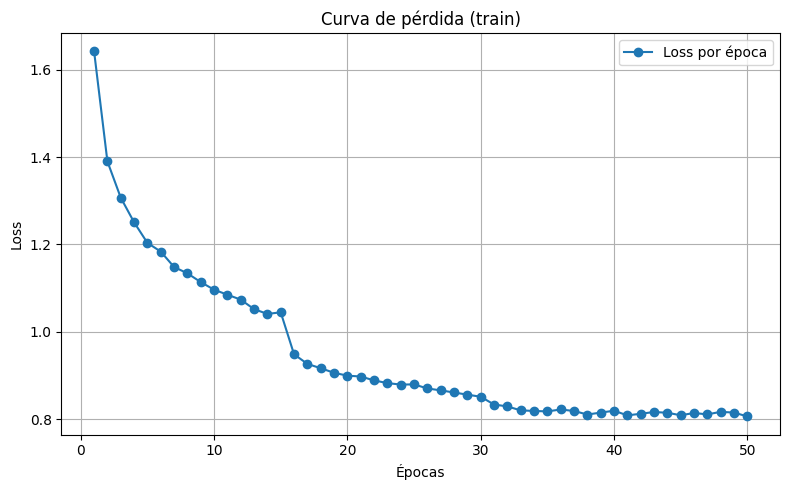

Epoch 50/50 - Loss media: 0.8059
Gráfica guardada: Graf_perd\loss_epoca_50.png

====== VALIDACIÓN ======
Accuracy: 68.21%
Kappa: 0.6389
F1 por clase: [0.81476299 0.55743208 0.78780134 0.61414589 0.71870391 0.48653705
 0.78926953 0.44740221 0.         0.64875134 0.59188933 0.56954195
 0.        ]
Matriz de confusión:
 [[56496084  6157135  6155125   246545  2109820    11687   870170   354656
      1360  2262303    42442     8917        0]
 [  567600 28937991  3878289  1228106  1599924    36112   435992   238755
    509433  5968710  1250188   995314        0]
 [ 5428749  7875576 71753608    74278  2354510    23060  1307017    16920
     11648  5028210   203521   307685        0]
 [   23607 10280070   113336 25925095  6754373   128147   301142   983690
    460003  4088822  1237754  2417473        0]
 [   99537   656688   298545   265184 27242016    16730   299454    34351
     70496  1656453   910606   100000        0]
 [   35681    83839   112924    67683    51041 10266101 11912690  16043

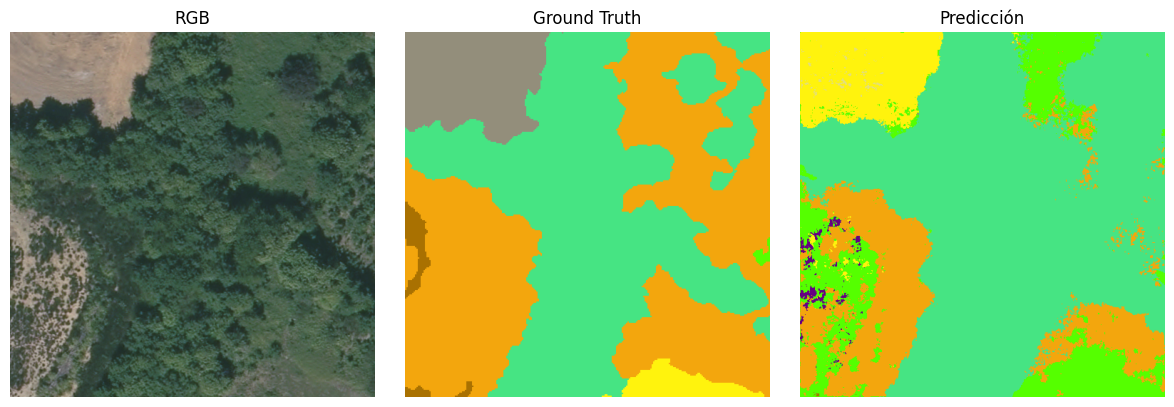

Ejemplo de validación guardado en:
  Predic_FLAIR_img\epoch_050_batch129_idx05_RGB_GT_PRED.png
Checkpoint guardado: Mod_SegNet_FLAIR_epoch\segnet_epoch_50_valF1_0.5405.pth

Modelo final guardado como 'Mod_SegNet_FLAIR_epoch\segnet_final.pth'


In [46]:
train_model(net, train_loader, val_loader, optimizer, 50, scheduler)

### 📑 Carga de un modelo entrenado (final o checkpoint intermedio)

Esta celda define la función `load_segnet_model`, diseñada para cargar de manera flexible
un modelo SegNet previamente entrenado, ya sea:

- un **archivo final** (`segnet_final.pth`), que contiene únicamente los pesos (`state_dict`), o  
- un **checkpoint** completo (`segnet_epoch_XX_valF1_XXXX.pth`), que además incluye el estado del optimizador, scheduler y la época alcanzada.

**Qué hace la función:**

- Verifica que el archivo exista.
- Detecta automáticamente si el archivo contiene:
  - solo un `state_dict`, o
  - un diccionario más completo con `"model_state"`.
- Carga los pesos en la instancia actual de `net`.
- Envía la red al dispositivo correspondiente (CPU/GPU).
- Cambia a modo evaluación (`net.eval()`).

Finalmente, la celda muestra un ejemplo de uso, permitiendo cargar:

- el modelo final, o  
- un checkpoint específico de entrenamiento.

Esta sección es esencial para evaluar modelos entrenados previamente sin necesidad
de repetir el proceso completo de entrenamiento.


In [76]:
# ============================================================
# CELDA — Cargar modelo entrenado (final o checkpoint)
# ============================================================

def load_segnet_model(net, path, device=DEVICE):

    if not os.path.exists(path):
        raise FileNotFoundError(f"No existe el archivo: {path}")

    print(f"Cargando modelo desde: {path}")
    ckpt = torch.load(path, map_location=device)

    # Caso A: archivo contiene SOLO los pesos
    if isinstance(ckpt, dict) and "model_state" in ckpt:
        print("→ Detectado: checkpoint con diccionario")
        net.load_state_dict(ckpt["model_state"])
        start_epoch = ckpt.get("epoch", None)
        print(f"Modelo cargado desde checkpoint (época {start_epoch}).")

    # Caso B: archivo es directamente state_dict
    else:
        print("→ Detectado: archivo con solo state_dict")
        net.load_state_dict(ckpt)
        print("Modelo cargado desde archivo final.")

    net.to(device)
    net.eval()

    print("✔ Modelo listo en modo evaluación.")
    return net


# ============================================================
# Ejemplo de uso (elige uno):
# ============================================================

# 1) Cargar modelo FINAL
model_path = "Mod_SegNet_FLAIR_epoch/segnet_final.pth"

# 2) Cargar un CHECKPOINT por época
# model_path = "Mod_SegNet_FLAIR_epoch/segnet_epoch_50_valF1_0.5026.pth"

# Cargar modelo
net = load_segnet_model(net, model_path, device=DEVICE)


Cargando modelo desde: Mod_SegNet_FLAIR_epoch/segnet_final.pth
→ Detectado: archivo con solo state_dict
Modelo cargado desde archivo final.
✔ Modelo listo en modo evaluación.


### 📝 Evaluación del modelo cargado sobre el conjunto de prueba

En esta celda:

1. Se carga nuevamente el modelo mediante `load_segnet_model` para asegurarse de que esté en modo evaluación.
2. Se ejecuta `evaluate_and_plot` usando el `test_loader`, lo que:
   - Calcula las métricas finales del modelo (Accuracy, F1 por clase, F1 ponderado, Kappa).
   - Construye y guarda la matriz de confusión normalizada en la carpeta de evaluación.
   - Imprime los valores detallados en consola.

Esta evaluación es el paso final del flujo de trabajo: permite cuantificar el rendimiento
del modelo en datos no vistos durante el entrenamiento, proporcionando una estimación real
de su capacidad de generalización.


Cargando modelo desde: Mod_SegNet_FLAIR_epoch/segnet_final.pth
→ Detectado: archivo con solo state_dict
Modelo cargado desde archivo final.
✔ Modelo listo en modo evaluación.

F1 por clase:
  00 - building            : 0.8148
  01 - pervious surface    : 0.5574
  02 - impervious surface  : 0.7878
  03 - bare soil           : 0.6141
  04 - water               : 0.7187
  05 - coniferous          : 0.4865
  06 - deciduous           : 0.7893
  07 - brushwood           : 0.4474
  08 - vineyard            : 0.0000
  09 - herbaceous vegetation: 0.6488
  10 - agricultural land   : 0.5919
  11 - plowed land         : 0.5695
  12 - other               : 0.0000



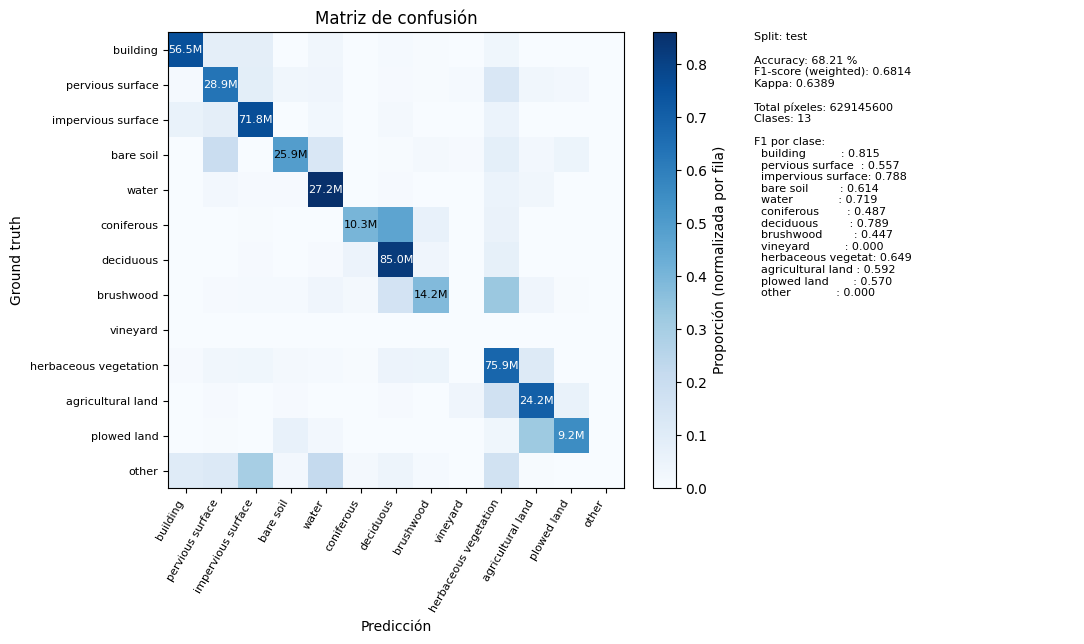

Figura de matriz de confusión guardada en: Evaluacion_mod_FLAIR\confusion_matrix_test.png


In [78]:
net = load_segnet_model(net, model_path)

f1_test, kappa_test, cm_test, f1_per_class_test, _ = evaluate_and_plot(
    net,
    test_loader,
    device=DEVICE,
    split_name="test"
)

### 🔍 Inferencia en el conjunto de prueba y exportación de resultados visuales

Esta celda realiza la inferencia final del modelo sobre el conjunto de prueba (`test_loader`)
y guarda para cada tile una tripleta visual compuesta por:

- **RGB** (imagen original)
- **GT** (ground truth colorizada)
- **PRED** (predicción del modelo colorizada)

El proceso se ejecuta tile por tile, usando `torch.no_grad()` y AMP para eficiencia.  
Se guarda un máximo de `MAX_TILES` resultados en la carpeta `Inferencias_FLAIR_tiles`,
incluyendo:

- una figura combinada en formato `RGB_GT_PRED.png`
- versiones individuales opcionales (`RGB.png`, `GT.png`, `PRED.png`)

Además, los primeros tres resultados se muestran en pantalla como ejemplo.  
Esta sección permite una inspección visual del desempeño del modelo y es fundamental
para análisis cualitativo tras el entrenamiento.


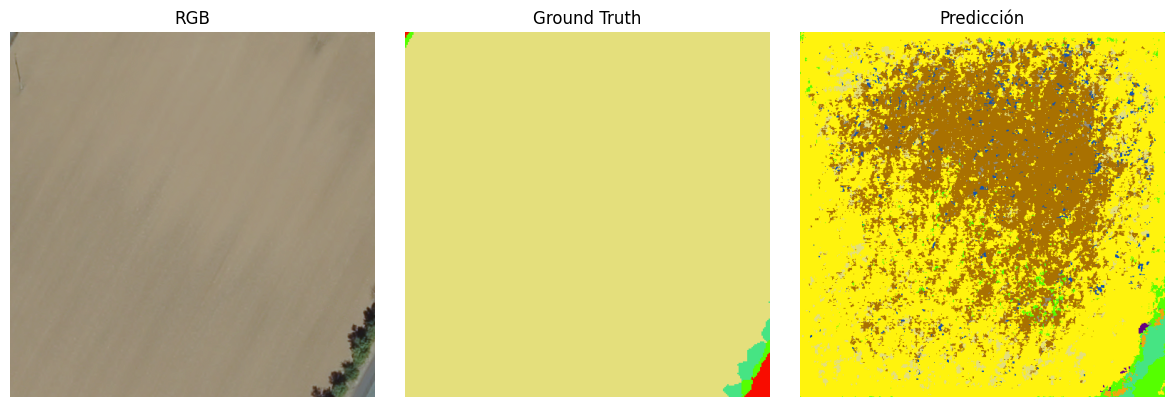

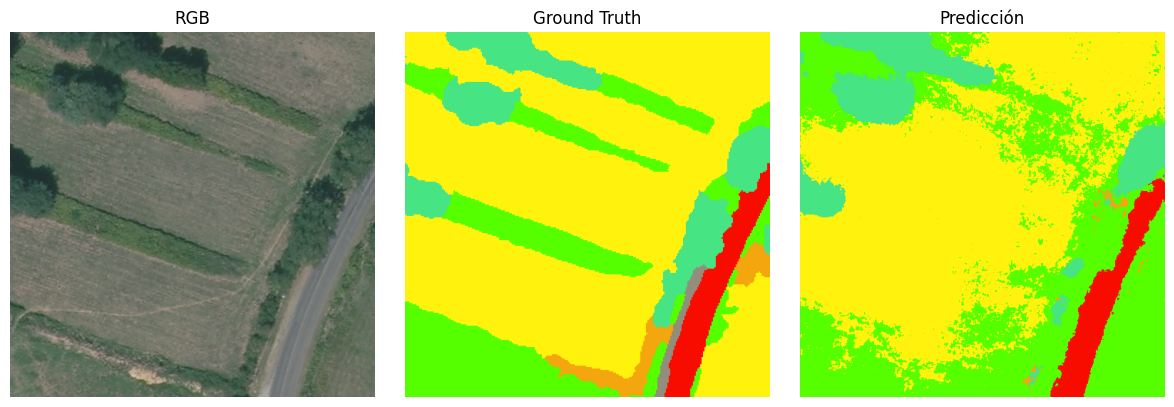

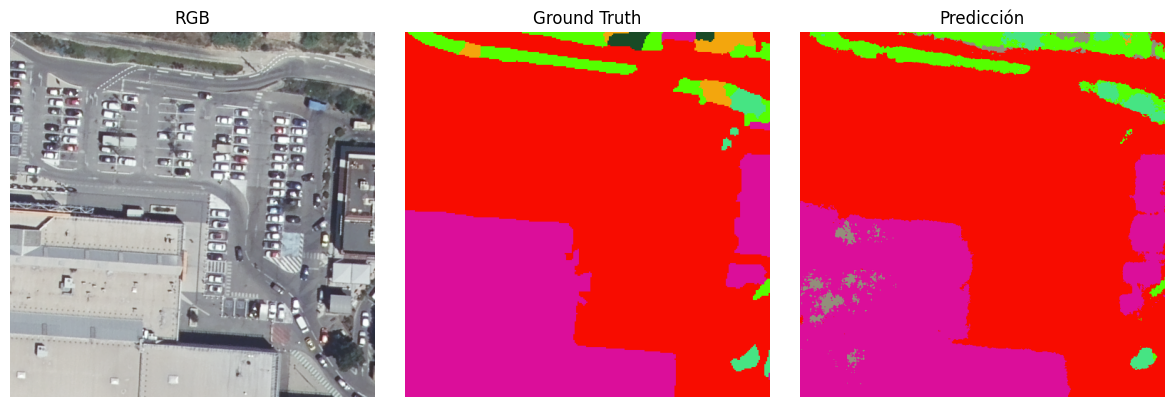

C:\Users\AVDON\anaconda3\envs\pytorch_env\lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ./Inferencias_FLAIR_tiles\IMG_001934_PRED.png is a low contrast image
  return func(*args, **kwargs)
C:\Users\AVDON\anaconda3\envs\pytorch_env\lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ./Inferencias_FLAIR_tiles\IMG_036928_GT.png is a low contrast image
  return func(*args, **kwargs)
C:\Users\AVDON\anaconda3\envs\pytorch_env\lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ./Inferencias_FLAIR_tiles\IMG_036928_PRED.png is a low contrast image
  return func(*args, **kwargs)
C:\Users\AVDON\anaconda3\envs\pytorch_env\lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ./Inferencias_FLAIR_tiles\IMG_061625_GT.png is a low contrast image
  return func(*args, **kwargs)


Se guardaron 15 tiles de test en: ./Inferencias_FLAIR_tiles


In [81]:
# ============================================================
# INFERENCIA EN TEST: GUARDAR RGB / GT / PRED POR TILE
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt

# Carpeta donde se guardarán las predicciones (tripleta RGB-GT-PRED)
INF_DIR = "./Inferencias_FLAIR_tiles"
os.makedirs(INF_DIR, exist_ok=True)

# Máximo de tiles de test que queremos guardar
MAX_TILES = 15  # Se puede modificar a gusto

net.eval()
saved = 0

with torch.no_grad():
    for idx, (imgs, msks) in enumerate(test_loader):
        if saved >= MAX_TILES:
            break

        imgs = imgs.to(DEVICE)
        msks = msks.to(DEVICE)

        # Forward con AMP
        with amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
            outputs = net(imgs)

        preds = torch.argmax(outputs, dim=1)  # (B, H, W)

        # Solo tomamos la primera imagen del batch (batch_size=1 en tu test_loader)
        rgb_tensor = imgs[0].detach().cpu().numpy()      # (C, H, W)
        gt_np      = msks[0].detach().cpu().numpy()      # (H, W)
        pred_np    = preds[0].detach().cpu().numpy()     # (H, W)

        # Pasar RGB de (C,H,W) a (H,W,C) y recortar valores
        rgb_vis = np.transpose(np.clip(rgb_tensor, 0, 1), (1, 2, 0))

        # Colorizar GT y Pred
        gt_color   = convert_to_color(gt_np)
        pred_color = convert_to_color(pred_np)

        # Nombre base usando el nombre original del tile
        img_path  = test_loader.dataset.image_paths[idx]
        base_name = os.path.splitext(os.path.basename(img_path))[0]

        # -------------------------------
        # 1) Figura combinada RGB / GT / Pred
        # -------------------------------
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(rgb_vis[..., :3])
        axes[0].set_title("RGB")
        axes[0].axis("off")

        axes[1].imshow(gt_color)
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        axes[2].imshow(pred_color)
        axes[2].set_title("Predicción")
        axes[2].axis("off")

        plt.tight_layout()

        combined_path = os.path.join(INF_DIR, f"{base_name}_RGB_GT_PRED.png")
        fig.savefig(combined_path, dpi=150, bbox_inches="tight")
        plt.close(fig)

        # -------------------------------
        # 2) (Opcional) Guardar cada imagen por separado
        # -------------------------------
        rgb_path = os.path.join(INF_DIR, f"{base_name}_RGB.png")
        gt_path  = os.path.join(INF_DIR, f"{base_name}_GT.png")
        pr_path  = os.path.join(INF_DIR, f"{base_name}_PRED.png")

        # Guardamos RGB en [0,255] uint8
        rgb_uint8 = (np.clip(rgb_vis[..., :3], 0, 1) * 255).astype(np.uint8)
        io.imsave(rgb_path, rgb_uint8)
        io.imsave(gt_path, gt_color.astype(np.uint8))
        io.imsave(pr_path, pred_color.astype(np.uint8))

        saved += 1

        # Mostrar en pantalla solo los primeros 3 como ejemplo
        if idx < 3:
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(rgb_vis[..., :3])
            axes[0].set_title("RGB")
            axes[0].axis("off")

            axes[1].imshow(gt_color)
            axes[1].set_title("Ground Truth")
            axes[1].axis("off")

            axes[2].imshow(pred_color)
            axes[2].set_title("Predicción")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

print(f"Se guardaron {saved} tiles de test en: {INF_DIR}")


### 💾 Guardado del modelo final (pesos + estructura completa)

En esta última celda se almacenan dos versiones del modelo entrenado:

1. **Pesos del modelo (`state_dict`)**  
   Guardados como `segnet_FLAIR_weights.pth`.  
   Este formato es el más recomendado para reutilizar el modelo en otros proyectos,
   ya que permite cargar los pesos en una instancia nueva de `SegNet`.

2. **Modelo completo (`torch.save(net)`)**  
   Guardado como `segnet_FLAIR_full.pth`.  
   Contiene tanto los pesos como la estructura completa del modelo, pero requiere que
   la clase `SegNet` esté definida de forma idéntica al volver a cargarlo.

Esta celda asegura la preservación final del modelo entrenado para uso futuro,
evaluaciones adicionales o despliegue.


In [92]:
# 1️⃣ Crear la carpeta si no existe
save_dir = "./modelo_SegNet_FLAIR"
os.makedirs(save_dir, exist_ok=True)

# 2️⃣ Definir las rutas de guardado
weights_path = os.path.join(save_dir, "segnet_FLAIR_weights.pth")
full_model_path = os.path.join(save_dir, "segnet_FLAIR_full.pth")

# 3️⃣ Guardar solo los pesos del modelo (state_dict)
torch.save(net.state_dict(), weights_path)
print(f"Pesos del modelo guardados en: {weights_path}")

# 4️⃣ Guardar el modelo completo (estructura + pesos)
torch.save(net, full_model_path)
print(f"Modelo completo guardado en: {full_model_path}")


Pesos del modelo guardados en: ./modelo_SegNet_FLAIR\segnet_FLAIR_weights.pth
Modelo completo guardado en: ./modelo_SegNet_FLAIR\segnet_FLAIR_full.pth
